In [120]:
#Imports
import xarray as xr
import numpy as np
import pandas as pd
from collections import OrderedDict
import csv
import math as ma
import matplotlib.pyplot as plt
import seaborn as sns
from cartopy import config
import cartopy.crs as ccrs
import warnings

In [121]:
# Returns equvalent to cdo fldmean
def fldmean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    return ds.mean(("lon", "lat"))

In [123]:
#Choose ERA5 or NCEP2. This switch also selects the eval/???? subfolders, so do not mix and match as this 
#would lead to incorrect results.
reanalysis='ERA5'

#Define paths
obs_path='obs/'
model_path='/p/project/chhb19/streffing1/software/cmpi-tool/input/'
out_path='output/'
eval_path='eval/'+reanalysis+'/'
time = '198912-201411'


#Define the name and evaluated variables for your model run


cmip6 = {
    'ACCESS-CM2':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'AWI-CM1-MR':   [           'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'BCC-SM2-MR':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CAMS':         [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CanESM5':      [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CAS-ESM2-0':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos',                         ],
    'CESM2':        [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos', 'mlotst'                ],
    'CIESM':        [           'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'CMCC-CM2-SR5': [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'CNRM-CM6-1-HR':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst'                ],
    'E3SM-1-1':     [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'EC-Earth3':    [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'FGOALS-f3-L':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'FIO-ESM-2-0':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'GISS-E2-1-G':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'HadGEM3MM':    [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'ICON-ESM-LR':  [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'IITM-ESM':     [           'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg',        'tos',                         ],
    'INM5':         [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg',                         'thetao', 'so'],
    'IPSL-CM6A-LR': [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'KIOST-ESM':    [ 'siconc', 'tas', 'clt',       'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst',               ],
    'MCMUA1':       [           'tas',        'pr', 'rlut', 'uas', 'vas', 'ua', 'zg',        'tos',           'thetao', 'so'],
    'MIROC6':       [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos',                         ],
    'MPI-ESM1-2-HR':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'MRI-ESM2-0':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas',             'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'NESM3':        [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],   
    'NOAA-GFDL':    [ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'NorESM2-MM':   [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so'],
    'SNU':          [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
    'TaiESM1':      [ 'siconc', 'tas', 'clt', 'pr', 'rlut',               'ua', 'zg', 'zos', 'tos',           'thetao', 'so'],
}

awi_cm3_ref= {
    'AWI-CM3-REF':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so']
}

awi_cm3_eof= {
    'AWI-CM3-EOF':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so']
}

awi_cm3_lr= {
    'AWI-CM3-LR':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst']
}

awi_esm1= {
    'AWI-ESM-1-1-LR':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so']
}

models = awi_cm3_ref

eval_models = cmip6

#Select for each variable which vertical levels shall be taken into account
var_depths ={    
        'siconc':['surface'],
        'tas':['surface'],
        'clt':['surface'],
        'pr':['surface'],
        'rlut':['surface'],
        'uas':['surface'],
        'vas':['surface'],
        'ua':['300hPa'],
        'zg':['500hPa'],
        'zos':['surface'],
        'tos':['surface'],
        'mlotst':['surface'],
        'thetao':['10m','100m','1000m'],
        'so':['10m','100m','1000m'],
}


#Define which observational dataset biases are computed against for each variable
obs = { 
    'siconc':'OSISAF',
    'tas':reanalysis,
    'clt':'MODIS',
    'pr':'GPCP',
    'rlut':'CERES',
    'uas':reanalysis,
    'vas':reanalysis,
    'ua':reanalysis,
    'zg':reanalysis,
    'zos':'NESDIS',
    'tos':'HadISST2',
    'mlotst':'C-GLORSv7',
    'thetao':'EN4',
    'so':'EN4',
}




In [124]:
#Select seasons
seasons = ['MAM', 'JJA', 'SON', 'DJF']

#Define regions
regions={'glob' : {
    'lat_min':-90,
    'lat_max':90,},
         
    'arctic' : {
    'lat_min':60,
    'lat_max':90,},
         
    'northmid' : {
    'lat_min':30,
    'lat_max':60,},
         
    'tropics' : {
    'lat_min':-30,
    'lat_max':30,},
         
    'innertropics' : {
    'lat_min':-15,
    'lat_max':15,},
         
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,},
         
    'antarctic' : {
    'lat_min':-90,
    'lat_max':-60,}
          
}

In [125]:
#Loading obs data
ds_obs = OrderedDict()
for var,depths in zip(obs,var_depths):
    for depth in np.arange(0,len(var_depths[depths])):
        for seas in seasons:
            print('loading '+obs_path+var+'_'+obs[var]+'_'+var_depths[depths][depth]+'_'+seas+'.nc')

            intermediate = xr.open_dataset(obs_path+var+'_'+obs[var]+'_'+var_depths[depths][depth]+'_'+seas+'.nc')
            ds_obs[var,var_depths[depths][depth],seas] = intermediate.compute()
            try:
                ds_obs[var,var_depths[var][depth],seas]=ds_obs[var,var_depths[var][depth],seas].drop('depth')
            except:
                pass
            

loading obs/siconc_OSISAF_surface_MAM.nc
loading obs/siconc_OSISAF_surface_JJA.nc
loading obs/siconc_OSISAF_surface_SON.nc
loading obs/siconc_OSISAF_surface_DJF.nc
loading obs/tas_ERA5_surface_MAM.nc
loading obs/tas_ERA5_surface_JJA.nc
loading obs/tas_ERA5_surface_SON.nc
loading obs/tas_ERA5_surface_DJF.nc
loading obs/clt_MODIS_surface_MAM.nc
loading obs/clt_MODIS_surface_JJA.nc
loading obs/clt_MODIS_surface_SON.nc
loading obs/clt_MODIS_surface_DJF.nc
loading obs/pr_GPCP_surface_MAM.nc
loading obs/pr_GPCP_surface_JJA.nc
loading obs/pr_GPCP_surface_SON.nc
loading obs/pr_GPCP_surface_DJF.nc
loading obs/rlut_CERES_surface_MAM.nc
loading obs/rlut_CERES_surface_JJA.nc
loading obs/rlut_CERES_surface_SON.nc
loading obs/rlut_CERES_surface_DJF.nc
loading obs/uas_ERA5_surface_MAM.nc
loading obs/uas_ERA5_surface_JJA.nc
loading obs/uas_ERA5_surface_SON.nc
loading obs/uas_ERA5_surface_DJF.nc
loading obs/vas_ERA5_surface_MAM.nc
loading obs/vas_ERA5_surface_JJA.nc
loading obs/vas_ERA5_surface_SON.nc


In [126]:
#Loading model data
ds_model = OrderedDict()

for model in models:
    for var in models[model]:
        for depth in np.arange(0,len(var_depths[var])):
            for seas in seasons:
                print('loading '+model_path+var+'_'+model+'_'+time+'_'+var_depths[var][depth]+'_'+seas+'.nc')
                intermediate = xr.open_dataset(model_path+var+'_'+model+'_'+time+'_'+var_depths[var][depth]+'_'+seas+'.nc')
                intermediate = intermediate.squeeze(drop=True)
                ds_model[var,var_depths[var][depth],seas,model] = intermediate.compute()
                try:
                    ds_model[var,var_depths[var][depth],seas,model]=ds_model[var,var_depths[var][depth],seas,model].drop('time_bnds')
                except:
                    pass
                try:
                    ds_model[var,var_depths[var][depth],seas,model]=ds_model[var,var_depths[var][depth],seas,model].drop('depth')
                except:
                    pass


loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_AWI-ESM-1-1-LR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_AWI-ESM-1-1-LR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_AWI-ESM-1-1-LR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_AWI-ESM-1-1-LR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-ESM-1-1-LR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-ESM-1-1-LR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-ESM-1-1-LR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-ESM-1-1-LR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_AWI-ESM-1-1-LR_198912-201411_surface_MAM.n

In [127]:
#Calculate absolute error and build field mean of abs error
abs_error = OrderedDict()
mean_error = OrderedDict()

for model in models:
    for var in models[model]:
        for depth in np.arange(0,len(var_depths[var])):
            for region in regions:
                filter1 = ds_model[var,var_depths[var][depth],seas,model].lat>regions[region]['lat_min']
                filter2 = ds_model[var,var_depths[var][depth],seas,model].lat<regions[region]['lat_max']
                for seas in seasons:
                    abs_error[var,var_depths[var][depth],seas,model,region]=np.sqrt((ds_model[var,var_depths[var][depth],seas,model].where(filter1 & filter2)-
                                                       ds_obs[var,var_depths[var][depth],seas]).where(filter1 & filter2)*
                                                      (ds_model[var,var_depths[var][depth],seas,model].where(filter1 & filter2)-
                                                       ds_obs[var,var_depths[var][depth],seas].where(filter1 & filter2)))
                    mean_error[var,var_depths[var][depth],seas,model,region] = fldmean(abs_error[var,var_depths[var][depth],seas,model,region])


In [128]:
#Write field mean of errors into csv files
for model in models:
    with open(out_path+'abs/'+model+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','AbsMeanError'])
        for var in models[model]:
            for region in regions:
                for depth in np.arange(0,len(var_depths[var])):
                    for seas in seasons:
                        writer.writerow([var,region,var_depths[var][depth],seas,np.squeeze(mean_error[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])])

In [129]:
#Read precalculated cmip6 field mean of errors from csv files

max_depth=0
for var in var_depths:
    if len(var_depths[var]) > max_depth:
        max_depth = len(var_depths[var])

collect = np.empty([len(eval_models),len(obs),len(regions),max_depth,len(seasons)])*np.nan
i=0
for eval_model in eval_models:
    df = pd.read_csv(eval_path+eval_model+'.csv', delimiter=' ')
    values = df['AbsMeanError'] #you can also use df['column_name']
    j=0
    r=0
    for var in obs:
        k=0
        a=(df['Variable']==var).to_list()
        if any(a): # Check if variable appears in list. If not, skip it.
            print('reading: ',eval_model,var)
        else:
            print('filling: ',eval_model,var)
        for region in regions:
            l=0
            for depth in np.arange(0,len(var_depths[var])):
                m=0
                for seas in seasons:
                    if any(a): # Check if variable appears in list. If not, skip it.
                        collect[i,j,k,l,m]=values[r]
                        r+=1
                    else:
                        collect[i,j,k,l,m]=np.nan
                    m+=1
                l+=1
            k+=1
        j+=1
    i+=1
# Ignoring non useful warning:
# /tmp/ipykernel_19478/363568120.py:37: RuntimeWarning: Mean of empty slice
#  ensmean=np.nanmean(collect,axis=0)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    ensmean=np.nanmean(collect,axis=0)


reading:  ACCESS-CM2 siconc
reading:  ACCESS-CM2 tas
reading:  ACCESS-CM2 clt
reading:  ACCESS-CM2 pr
reading:  ACCESS-CM2 rlut
reading:  ACCESS-CM2 uas
reading:  ACCESS-CM2 vas
reading:  ACCESS-CM2 ua
reading:  ACCESS-CM2 zg
reading:  ACCESS-CM2 zos
reading:  ACCESS-CM2 tos
reading:  ACCESS-CM2 mlotst
reading:  ACCESS-CM2 thetao
reading:  ACCESS-CM2 so
filling:  AWI-CM1-MR siconc
reading:  AWI-CM1-MR tas
reading:  AWI-CM1-MR clt
reading:  AWI-CM1-MR pr
reading:  AWI-CM1-MR rlut
reading:  AWI-CM1-MR uas
reading:  AWI-CM1-MR vas
reading:  AWI-CM1-MR ua
reading:  AWI-CM1-MR zg
reading:  AWI-CM1-MR zos
reading:  AWI-CM1-MR tos
reading:  AWI-CM1-MR mlotst
reading:  AWI-CM1-MR thetao
reading:  AWI-CM1-MR so
reading:  BCC-SM2-MR siconc
reading:  BCC-SM2-MR tas
reading:  BCC-SM2-MR clt
reading:  BCC-SM2-MR pr
reading:  BCC-SM2-MR rlut
reading:  BCC-SM2-MR uas
reading:  BCC-SM2-MR vas
reading:  BCC-SM2-MR ua
reading:  BCC-SM2-MR zg
reading:  BCC-SM2-MR zos
reading:  BCC-SM2-MR tos
reading:  BC

reading:  TaiESM1 siconc
reading:  TaiESM1 tas
reading:  TaiESM1 clt
reading:  TaiESM1 pr
reading:  TaiESM1 rlut
filling:  TaiESM1 uas
filling:  TaiESM1 vas
reading:  TaiESM1 ua
reading:  TaiESM1 zg
reading:  TaiESM1 zos
reading:  TaiESM1 tos
filling:  TaiESM1 mlotst
reading:  TaiESM1 thetao
reading:  TaiESM1 so


In [130]:
#Place sums of error into easier to inspect dictionary
eval_error_mean = OrderedDict()
j=0
for var in obs:
    k=0
    for region in regions:
        l=0
        for depth in np.arange(0,len(var_depths[var])):
            m=0
            for seas in seasons:
                eval_error_mean[var,region,var_depths[var][depth],seas]=ensmean[j,k,l,m]
                m+=1
            l+=1
        k+=1
    j+=1

In [131]:
#calculate ratio of current model error to evaluation model error
error_fraction = OrderedDict()
sum=0
for model in models:
    for var in models[model]:
        for region in regions:
            for depth in np.arange(0,len(var_depths[var])):
                for seas in seasons:
                    error_fraction[var,var_depths[var][depth],seas,model,region] = mean_error[var,var_depths[var][depth],seas,model,region] / eval_error_mean[var,region,var_depths[var][depth],seas]


In [132]:
#Write ratio of field mean of errors into csv files and sum up error fractions for cmpi score
#TODO beautification: find way to access error_fraction[var,seas,model,region].var.values[0] to make
#one call out of nine
cmpi = OrderedDict()
for model in models:
    sum=0
    iter=0
    with open(out_path+'frac/'+model+'_fraction.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','FracMeanError'])
        for var in models[model]:
            for depth in np.arange(0,len(var_depths[var])):
                for region in regions:
                    for seas in seasons:
                        writer.writerow([var,region,var_depths[var][depth],seas,np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])])
                        if ma.isnan(np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])):
                            pass
                        else:
                            sum+=np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])
                            iter+=1
        cmpi[model]=np.squeeze(sum)/iter
        writer.writerow(['CMPI','global','yearly',cmpi[model]])

reading:  AWI-ESM-1-1-LR siconc
reading:  AWI-ESM-1-1-LR tas
reading:  AWI-ESM-1-1-LR clt
reading:  AWI-ESM-1-1-LR pr
reading:  AWI-ESM-1-1-LR rlut
reading:  AWI-ESM-1-1-LR uas
reading:  AWI-ESM-1-1-LR vas
reading:  AWI-ESM-1-1-LR ua
reading:  AWI-ESM-1-1-LR zg
reading:  AWI-ESM-1-1-LR zos
reading:  AWI-ESM-1-1-LR tos
reading:  AWI-ESM-1-1-LR mlotst
reading:  AWI-ESM-1-1-LR thetao
reading:  AWI-ESM-1-1-LR so
AWI-ESM-1-1-LR number of values:  504 ; shape: 18 x 28


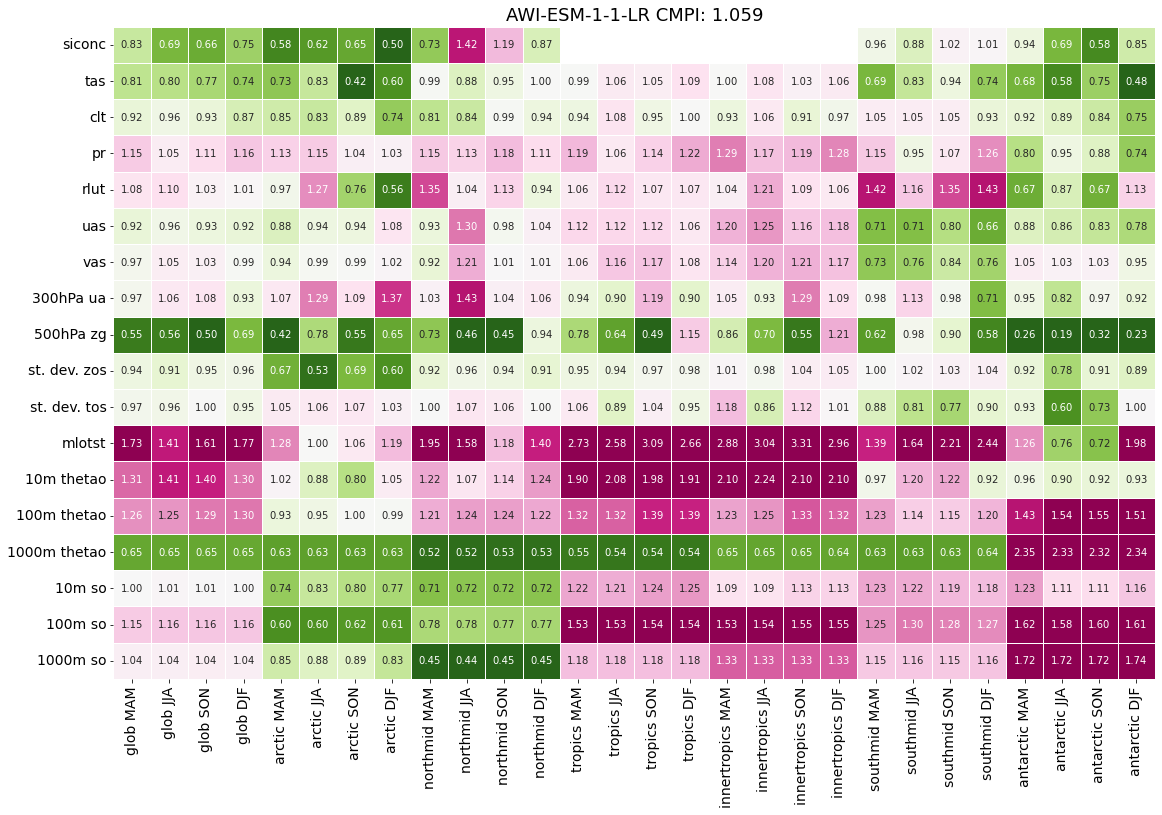

In [133]:
#Read precalculated evaluation field means of errors from csv files and plot heatmap
max_depth=0
for var in var_depths:
    if len(var_depths[var]) > max_depth:
        max_depth = len(var_depths[var])

plt.rcParams.update({'figure.max_open_warning': 0})
collect_frac_non = OrderedDict()
for model in models:
    df = pd.read_csv(out_path+'frac/'+model+'_fraction.csv', delimiter=' ')
    values = df['FracMeanError'] #you can also use df['column_name']
    r=0
    for var in obs:
        a=(df['Variable']==var).to_list()
        if any(a): # Check if variable appears in list. If not, skip it.
            print('reading: ',model,var)
        else:
            print('filling: ',model,var)
        for depth in np.arange(0,len(var_depths[var])):
            for region in regions:
                for seas in seasons:
                    if any(a):
                        collect_frac_non[var+' '+region,var_depths[var][depth]+' '+seas]=values[r]
                        r+=1
                    else:
                        collect_frac_non[var+' '+region,var_depths[var][depth]+' '+seas]=np.nan


    seasons_plot = [' MAM', ' JJA', ' SON', ' DJF'] #adding spaces in front
    a=seasons_plot*len(regions)
    b=np.repeat(list(regions.keys()),len(seasons_plot))
    coord=[n+str(m) for m,n in zip(a,b)]
    
    index_obs=[]
    for var in obs:
        for depth in np.arange(0,len(var_depths[var])):
            if var_depths[var][depth] == 'surface':
                levelname=''
            else:
                levelname=var_depths[var][depth]+' '
            if var == 'zos' or var == 'tos':
                levelname='st. dev. '
            index_obs.append(levelname+var)
    print(model,'number of values: ',len(list(collect_frac_non.values())),'; shape:',len(index_obs),'x',len(regions)*len(seasons))
    collect_frac_reshaped = np.array(list(collect_frac_non.values()) ).reshape(len(index_obs),len(regions)*len(seasons)) # transform to 2D
    collect_frac_dataframe = pd.DataFrame(data=collect_frac_reshaped, index=index_obs, columns=coord)

    fig, ax = plt.subplots(figsize=((len(regions)*len(seasons))/1.5,len(index_obs)/1.5))
    fig.patch.set_facecolor('white')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = sns.heatmap(collect_frac_dataframe, vmin=0.5, vmax=1.5,center=1,annot=True,fmt='.2f',cmap="PiYG_r",cbar=False,linewidths=1)
    plt.xticks(rotation=90,fontsize=14)
    plt.yticks(rotation=0, ha='right',fontsize=14)
    plt.title(model+' CMPI: '+str(round(cmpi[model],3)), fontsize=18)
    
    plt.savefig(out_path+'plot/'+model+'.png',dpi=200,bbox_inches='tight')
    i+=1


/p/project/chhb19/jstreffi/software/miniconda3/envs/pyfesom2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


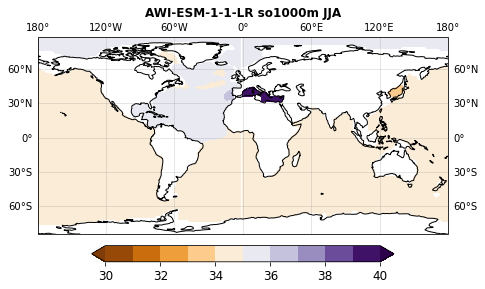

In [134]:
# Debug plot script

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import math

#model='BCC-SM2-MR'
#model='AWI-CM3-REF'
#model='AWI-CM1-MR'
depth=2
levels=np.linspace(30,40,11)
#levels=np.linspace(0,1000,11)
seas='JJA'
var='so'

%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,zorder=3)


data = ds_model[var,var_depths[var][depth],seas,model].to_array(var).values[0]
obsp = np.squeeze(ds_obs[var,var_depths[var][depth],seas].to_array(var).values[0])
data_to_plot = data[0:90,:]#-obsp[0:90,:]
#data_to_plot = obsp[0:90,:]

lon = np.arange(0, 360, 2)
lat = np.arange(-90, 90, 2)

imf=plt.contourf(lon, lat, data_to_plot, cmap=plt.cm.PuOr,levels=levels, extend='both', transform=ccrs.PlateCarree())

ax.set_title(model+' '+var+var_depths[var][depth]+' '+seas,fontweight="bold")
plt.tight_layout() 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.2, linestyle='-')

gl.xlabels_bottom = False    
cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
cbar_ax_abs.tick_params(labelsize=12)
cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal')
cb.ax.tick_params(labelsize='12')
